# Practical Two: Species Distribution Modelling

## Required packages

There are many R packages available for species distribution modelling. If you search
through the [CRAN package index](https://cran.r-project.org/web/packages/index.html) for
'species distribution', you will find over 20 different packages that do something - and
that is only using a single search term.

We are going to concentrate on the `dismo` package: it is a little old but provides a
single framework to handle different model types. It also has an excellent **vignette**
(a detailed tutorial on how to use the package) for further details:

[https://cran.r-project.org/web/packages/dismo/vignettes/sdm.pdf](https://cran.r-project.org/web/packages/dismo/vignettes/sdm.pdf)

One thing to note is that `dismo` is still built around the older `raster` package and
expects inputs to be as `Raster` objects from that package. You will see this code used
below to convert a `terra::SpatRaster` object to `raster::Raster` object:

```r
raster_obj <- as(spat_raster_obj, 'Raster')
```

We will need to load the following packages. Remember to read [this guide on setting up
packages on your computer](../required_packages.md) if you are running these practicals
on your own machine, not RStudio Cloud.

To load the packages:

In [1]:
library(terra)
library(geodata)

library(raster)
library(sf)
library(sp)

library(dismo)

terra 1.6.17



Loading required package: sp



Linking to GEOS 3.10.2, GDAL 3.5.0, PROJ 9.0.0; sf_use_s2() is TRUE



<!-- ### Installing MaxEnt

We are going to be using the MAXENT species distribution modelling program. Using MaxEnt
in R is a bit of a pain, because it requires the MAXENT program to be separately
installed and also requires the `rJava` package. The RStudio Cloud project for this
practical is all ready to go, but if you want to follow this on your own machine then
you will need to:

1. Download the MAXENT program - this is a compiled Java program file `maxent.jar`:

[https://github.com/mrmaxent/Maxent/blob/master/ArchivedReleases/3.3.3k/maxent.jar?raw=true](https://github.com/mrmaxent/Maxent/blob/master/ArchivedReleases/3.3.3k/maxent.jar?raw=true)

2. Save that into the `dismo/java` folder in your R library.

MaxEnt is a very widely used program that uses a Maximum Entropy approach to fit species
models. We are *not* going to be getting into the details of the way the algorithm
works, but you can read up on that here:

> Elith, J., Phillips, S.J., Hastie, T., Dudík, M., Chee, Y.E. and Yates, C.J. (2011), A
> statistical explanation of MaxEnt for ecologists. Diversity and Distributions, 17:
> 43-57.
> [doi:10.1111/j.1472-4642.2010.00725.x](https://doi.org/10.1111/j.1472-4642.2010.00725.x)

It [has been pointed
out](https://methodsblog.com/2013/02/20/some-big-news-about-maxent/) that MaxEnt is
actually equivalent to a Generalised Linear Model (GLM), but we will use a few
approaches here and MaxEnt is a framework that has been widely used and discussed.

-->

## Introduction

This practical gives a basic introduction to species distribution modelling using R. We
will be using R to characterise a selected species environmental requirements under
present day climatic conditions and then projecting the availability of suitable
climatic conditions into the future. This information will then be used to analyse
projected range changes due to climate change. During this process we will analyse the
performance of species distribution models and the impacts of threshold choice, variable
selection and data availability on model quality.

## Data preparation

There are two main inputs to a species distribution model. The first is a set of points
describing locations in which the species is known to be found. The second is a set of
environmental raster layers – these are the variables that will be used to characterise
the species’ environmental niche by looking at the environmental values where the
species is found.

### Focal species distribution

We will be using the Mountain Tapir (_Tapirus pinchaque_) as an example species.

![Tapirus pinchaque. © Diego Lizcano](images/tapirus-pinchaque.jpg)  
_Tapirus pinchaque_. © Diego Lizcano

I have picked this because it has a fairly narrow distribution but also because there is
reasonable data in two distribution data sources:

- The IUCN Red List database:
  [Mountain Tapir](https://www.iucnredlist.org/species/21473/45173922), which is a good
  source of polygon species ranges. These ranges are usually _expert drawn maps_:
  interpretations of sighting data and local information.

- The GBIF database: [Mountain Tapir](https://www.gbif.org/species/2440899), which is a
  source of point observations of species.

It is hugely important to be critical of point observation data and carefully clean it.
There is a great description of this process in the `dismo` vignette on species
distribution modelling:

```r
vignette('sdm')
```

There are many other issues that creep into GBIF data, so if you end up using GBIF data
in research, you should also look at the
[CoordinateCleaner](https://cloud.r-project.org/web/packages/CoordinateCleaner/index.html)
package, which provides a huge range of checks on coordinate data.

We can view both kinds of data for this species.

- The IUCN data is a single MULTIPOLYGON feature showing the discontinuous sections of
  the species' range. There are a number of feature attributes, described in detail in
  [this pdf](https://nc.iucnredlist.org/redlist/resources/files/1539098236-Mapping_Standards_Version_1.16_2018.pdf).

In [2]:
tapir_IUCN <- st_read('data/sdm/iucn_mountain_tapir/data_0.shp')
print(tapir_IUCN)

Reading layer `data_0' from data source 
  `/Users/dorme/Teaching/GIS/Masters_GIS_2020/practicals/practical_data/sdm/iucn_mountain_tapir/data_0.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 15 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -79.62289 ymin: -5.962554 xmax: -73.82314 ymax: 5.031971
Geodetic CRS:  WGS 84


Simple feature collection with 1 feature and 15 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -79.62289 ymin: -5.962554 xmax: -73.82314 ymax: 5.031971
Geodetic CRS:  WGS 84
  ASSESSMENT ID_NO          BINOMIAL PRESENCE ORIGIN SEASONAL COMPILER YEAR
1   45173922 21473 Tapirus pinchaque        1      1        1     IUCN 2008
                                               CITATION            LEGEND
1 IUCN (International Union for Conservation of Nature) Extant (resident)
  SUBSPECIES SUBPOP DIST_COMM ISLAND TAX_COMM                       geometry
1       <NA>   <NA>      <NA>   <NA>     <NA> MULTIPOLYGON (((-78.00009 0...


- The GBIF data is a table of observations, some of which include coordinates. One thing
  that GBIF does is to publish a DOI for every download, to make it easy to track
  particular data use. This one is
  [https://doi.org/10.15468/dl.t2bkzx](https://doi.org/10.15468/dl.t2bkzx).

There are some tricks to loading the GBIF data:

- Although GBIF use the file `.csv` suffix, the file is in fact _tab_ delimited so we
  need to use `read.delim()`.
- We also need to remove rows with no coordinates.

In [3]:
# Load the data frame
tapir_GBIF <- read.delim('data/sdm/gbif_mountain_tapir.csv')

# Drop rows with missing coordinates
tapir_GBIF <- subset(tapir_GBIF, ! is.na(decimalLatitude) | ! is.na(decimalLongitude))

# Convert to an sf object and set the projection
tapir_GBIF <- st_as_sf(tapir_GBIF, coords=c('decimalLongitude', 'decimalLatitude'))
st_crs(tapir_GBIF) <- 4326

We can now superimpose the two datasets to show they _broadly_ agree. There aren't any
obvious problems that require data cleaning.

In [4]:
# Load some (coarse) country background data
ne110 <- st_read('data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

Reading layer `ne_110m_admin_0_countries' from data source 
  `/Users/dorme/Teaching/GIS/Masters_GIS_2020/practicals/practical_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 177 features and 168 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -180 ymin: -90 xmax: 180 ymax: 83.64513
Geodetic CRS:  WGS 84


In [5]:
options(repr.plot.width=8, repr.plot.height= 8) # Change plot sizes (in cm)

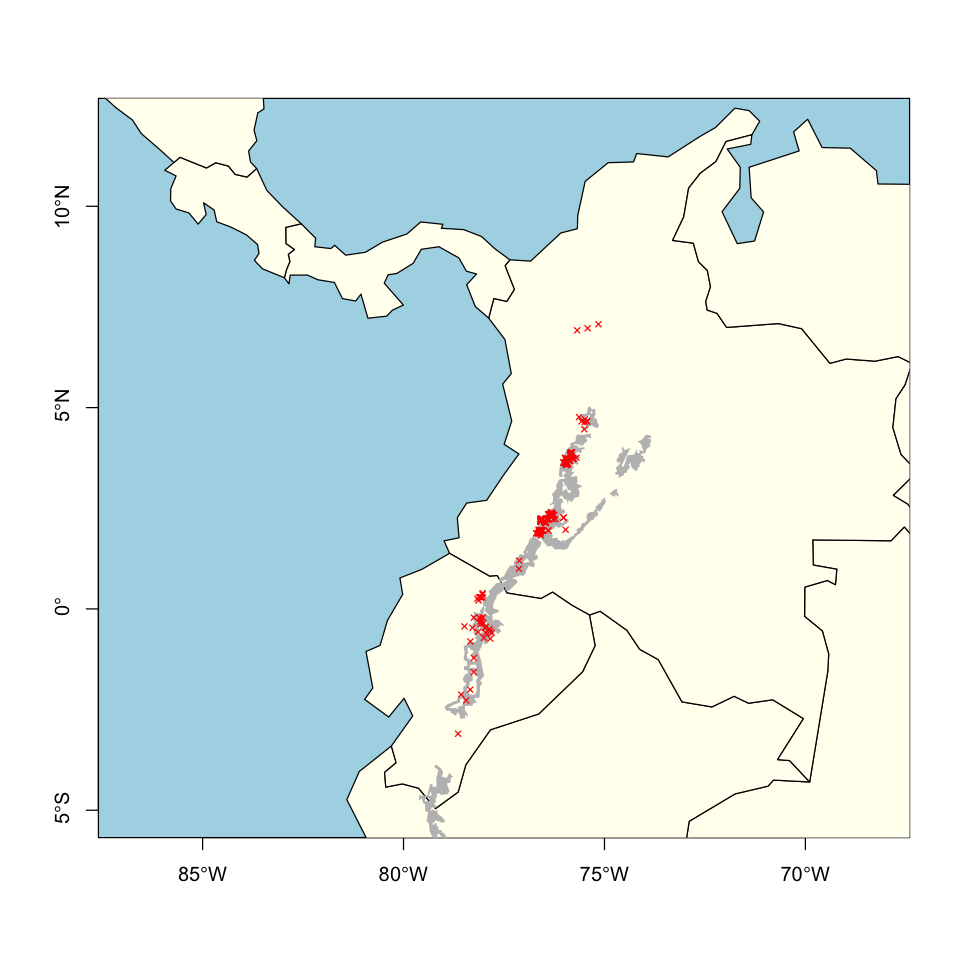

In [6]:
# Create a modelling extent for plotting and cropping the global data.
model_extent <- extent(c(-85,-70,-5,12))

# Plot the species data over a basemap
plot(st_geometry(ne110), xlim=model_extent[1:2], ylim=model_extent[3:4], 
     bg='lightblue', col='ivory', axes=TRUE)
plot(st_geometry(tapir_IUCN), add=TRUE, col='grey', border=NA)
plot(st_geometry(tapir_GBIF), add=TRUE, col='red', pch=4, cex=0.6)

### Predictor variables

Several sources of different environmental data were mentioned in the lecture, but in
this practical we will be using climatic variables to describe the environment. In
particular, we will be using the BIOCLIM variables. These are based on simple
temperature and precipitation values, but in 19 combinations that are thought to capture
more biologically relevant aspects of the climate. These variables are described here:

[https://www.worldclim.org/data/bioclim.html](https://www.worldclim.org/data/bioclim.html)

The data we will use here have already been downloaded using the
`geodata::worldclim_global` and `geodata::cmip6_world` functions. If you are using your
own computer, this code will fetch the data first. The two datasets loaded contain
averages across two time periods:

- _historical_ climate data (1970 - 2000), and
- _projected future_ climate (2041 - 2060) taken from the Hadley GEM3 model using the
  [SSP5-8.5](https://en.wikipedia.org/wiki/Shared_Socioeconomic_Pathways) Shared
  Socioeconomic Pathway.

Both these datasets are sourced from
[http://www.worldclim.org](http://www.worldclim.org) and contain a stack of the 19
BIOCLIM variables at 10 arc-minute resolution
($10' = \dfrac{1}{6}° \approx 15\, \text{km}$).

In [7]:
# Load the data
bioclim_hist <- worldclim_global(var='bio', res=10, path='data')
bioclim_future <- cmip6_world(var='bioc', res=10, ssp="585", 
                             model='HadGEM3-GC31-LL', time="2041-2060", path='data')
 
# Relabel the variables to match between the two dataset
bioclim_names <- paste0('bio', 1:19)
names(bioclim_future) <- bioclim_names
names(bioclim_hist) <- bioclim_names

# Look at the data structure
print(bioclim_hist)

class       : SpatRaster 
dimensions  : 1080, 2160, 19  (nrow, ncol, nlyr)
resolution  : 0.1666667, 0.1666667  (x, y)
extent      : -180, 180, -90, 90  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
sources     : wc2.1_10m_bio_1.tif  
              wc2.1_10m_bio_2.tif  
              wc2.1_10m_bio_3.tif  
              ... and 16 more source(s)
names       :      bio1,     bio2,       bio3,     bio4,      bio5,      bio6, ... 
min values  : -54.72435,  1.00000,   9.131122,    0.000, -29.68600, -72.50025, ... 
max values  :  30.98764, 21.14754, 100.000000, 2363.846,  48.08275,  26.30000, ... 


In [8]:
print(bioclim_future)

class       : SpatRaster 
dimensions  : 1080, 2160, 19  (nrow, ncol, nlyr)
resolution  : 0.1666667, 0.1666667  (x, y)
extent      : -180, 180, -90, 90  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : wc2.1_10m_bioc_HadGEM3-GC31-LL_ssp585_2041-2060.tif 
names       :  bio1, bio2,  bio3,   bio4,  bio5,  bio6, ... 
min values  : -51.9, -1.7, -16.7,   13.9, -27.3, -69.8, ... 
max values  :  34.3, 21.0,  94.8, 2338.2,  52.5,  27.1, ... 


We can compare `BIO 1` (Mean Annual Temperature) between the two datasets:

In [9]:
options(repr.plot.width=14, repr.plot.height= 7) # Change plot sizes (in cm)

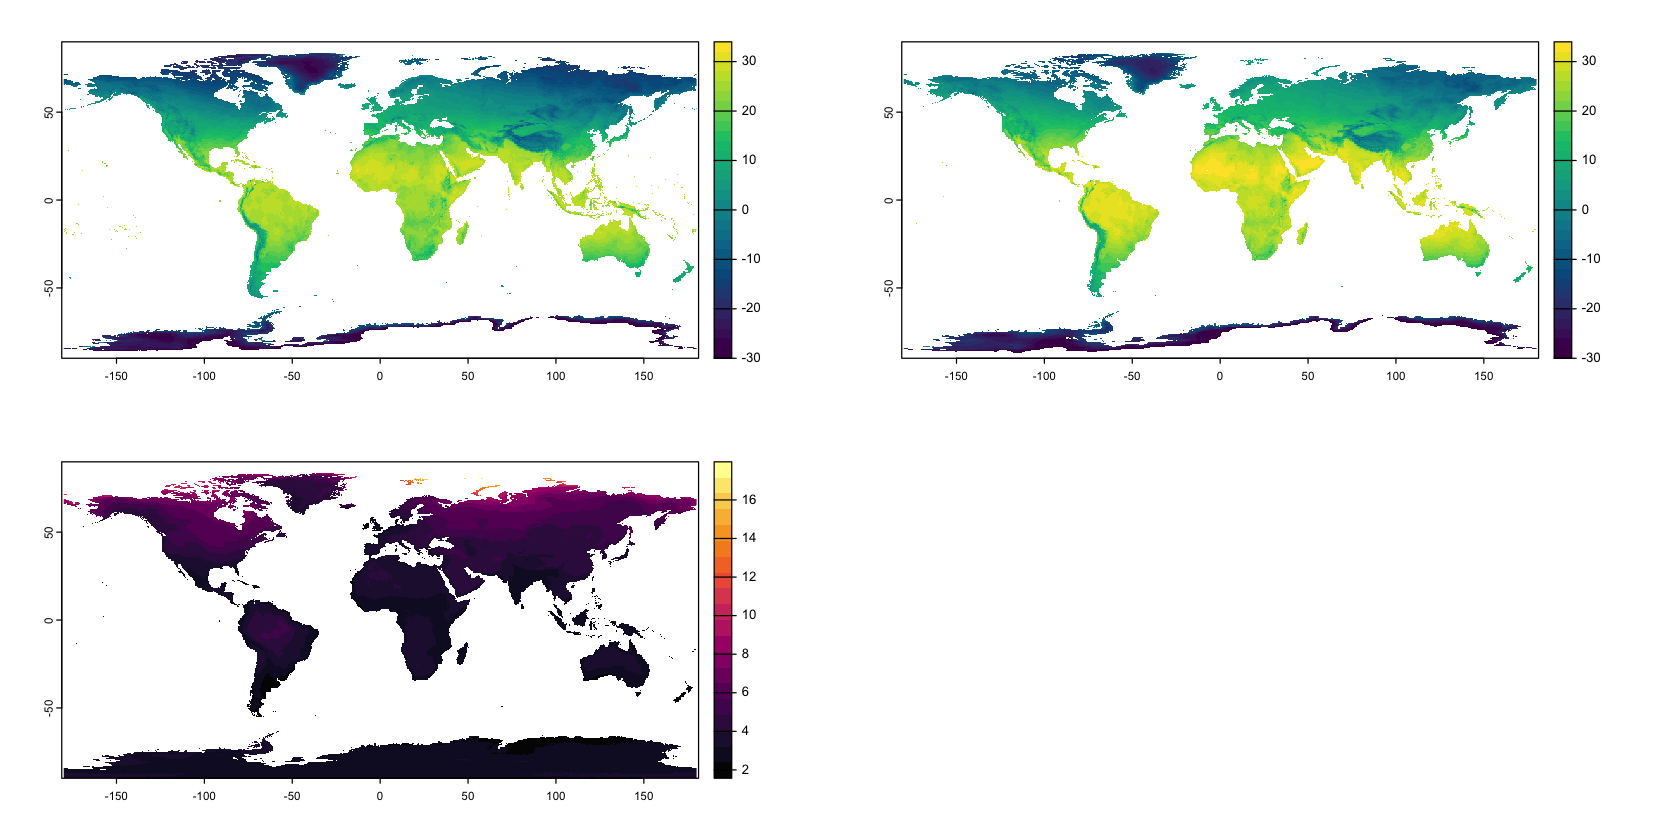

In [10]:
par(mfrow=c(2,2), mar=c(1,1,1,1))

# Create a shared colour scheme
breaks <- seq(-30, 35, by=2)
cols <- hcl.colors(length(breaks) - 1)

# Plot the historical and projected data
plot(bioclim_hist[[1]], breaks=breaks, col=cols, 
     type='continuous', plg=list(ext=c(190,200,-90,90)))
plot(bioclim_future[[1]], breaks=breaks, col=cols, 
     type='continuous', plg=list(ext=c(190,200,-90,90)))

# Plot the temperature difference
plot(bioclim_future[[1]] - bioclim_hist[[1]], 
     col=hcl.colors(20, palette='Inferno'), breakby='cases',
     type='continuous', plg=list(ext=c(190,200,-90,90)))

We are immediately going to crop the environmental data down to a sensible modelling
region. What counts as _sensible_ here is very hard to define and you may end up
changing it when you see model outputs, but here we use a small spatial subset to make
things run quickly.

In [11]:
# Reduce the global maps down to the species' range
bioclim_hist_local <- crop(bioclim_hist, model_extent)
bioclim_future_local <- crop(bioclim_future, model_extent)

### Reproject the data

All of our data so far has been in the WGS84 geographic coordinate system. We now need
to reproject the data into an appropriate projected coordinate system: the
[Universal Transverse Mercator Zone 18S](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
is a good choice for this region.

For the raster data, if we just specify the projection, then the `terra` package picks a
resolution and extent that best approximates the original data.

In [12]:
test <-  project(bioclim_hist_local, 'EPSG:32718')
ext(test)

SpatExtent : -618479.596609369, 1065045.31979816, 9441019.82660742, 11346548.0286951 (xmin, xmax, ymin, ymax)

In [13]:
res(test)  # Resolution in metres on X and Y axes

[1] 18500.27 18500.27

There isn't anything really wrong with that, but having round numbers for the grid
extent and resolution is a bit easier to describe and work with. We can create the
specific grid we want and project the data into that.

In [14]:
# Define a new projected grid
 utm18s_grid <- rast(ext(-720000, 1180000, 9340000, 11460000), 
                       res=20000, crs='EPSG:32718')

# Reproject the model data
bioclim_hist_local <- project(bioclim_hist_local, utm18s_grid)
bioclim_future_local <- project(bioclim_future_local, utm18s_grid)

Now we can also reproject the species distribution vector data:

In [15]:
tapir_IUCN <- st_transform(tapir_IUCN, crs='EPSG:32718')
tapir_GBIF <- st_transform(tapir_GBIF, crs='EPSG:32718')

### Pseudo-absence data

Many of the methods below require **absence data**, either for fitting a model or for
evaluating the model performance. Rarely, we might actually have real absence data from
exhaustive surveys, but usually we only have presence data. So, modelling commonly uses
_pseudo-absence_ or _background_ locations. The difference between those two terms is
subtle: I haven't seen a clean definition but _background_ data might be sampled
completely at random, where _pseudo-absence_ makes some attempt to pick locations that
are somehow separated from presence observations.

The `dismo` package provides the `randomPoints` function to select background data. It
is useful because it works directly with the environmental layers to pick **points
representing cells**. This avoids getting duplicate points in the same cells. You do
need to provide a **mask layer** that shows which cells are valid choices. You can also
exclude cells that contain observed locations by setting `p` to use the coordinates of
your observed locations.

In [16]:
# Create a simple land mask
land <- bioclim_hist_local[[1]] >= 0

# How many points to create? We'll use the same as number of observations
n_pseudo <- nrow(tapir_GBIF)

# Sample the points
pseudo_dismo <- randomPoints(mask=as(land, 'Raster'), n=n_pseudo, 
                             p=st_coordinates(tapir_GBIF))

# Convert this data into an sf object, for consistency with the
# next example.
pseudo_dismo <- st_as_sf(data.frame(pseudo_dismo), coords=c('x','y'), crs=32718)

We can also use GIS to do something a little more sophisticated. This isn't necessarily
the best choice here, but is an example of how to do something more structured. The aim
here is to pick points that are within 100 km of observed points, but not closer than
20km. The units of the projection is metres, so we multiply by 1000.

In [17]:
# Create buffers around the observed points
nearby <- st_buffer(tapir_GBIF, dist=100000)
too_close <- st_buffer(tapir_GBIF, dist=20000)
# merge those buffers
nearby <- st_union(nearby)
too_close <- st_union(too_close)
# Find the area that is nearby but _not_ too close
nearby <- st_difference(nearby, too_close)
# Get some points within that feature in an sf dataframe
pseudo_nearby <- st_as_sf(st_sample(nearby, n_pseudo))

We can plot those two points side by side for comparison.

In [18]:
options(repr.plot.width=12, repr.plot.height= 6) # Change plot sizes (in cm)

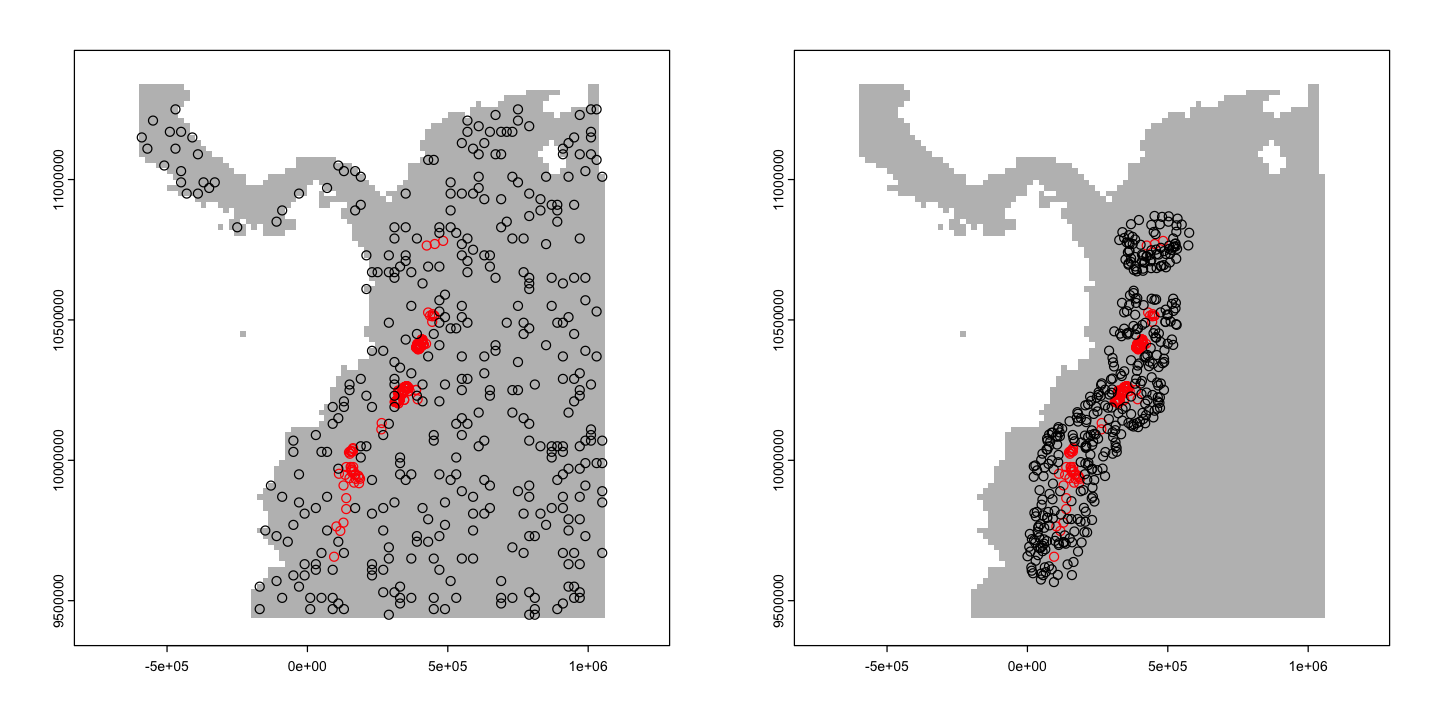

In [19]:
par(mfrow=c(1,2), mar=c(1,1,1,1))

# Random points on land
plot(land, col='grey', legend=FALSE)
plot(st_geometry(tapir_GBIF), add=TRUE, col='red')
plot(pseudo_dismo, add=TRUE)

# Random points within ~ 100 km but not closer than ~ 20 km
plot(land, col='grey', legend=FALSE)
plot(st_geometry(tapir_GBIF), add=TRUE, col='red')
plot(pseudo_nearby, add=TRUE)

A really useful starting point for further detail on pseudo absences is the following
study:

> Barbet‐Massin, M., Jiguet, F., Albert, C.H. and Thuiller, W. (2012), Selecting
> pseudo‐absences for species distribution models: how, where and how many?. Methods in
> Ecology and Evolution, 3: 327-338.
> [doi:10.1111/j.2041-210X.2011.00172.x](https://doi:10.1111/j.2041-210X.2011.00172.x)

### Testing and training dataset

One important part of the modelling process is to keep separate data for _training_ the
model (the process of fitting the model to data) and for _testing_ the model (the
process of checking model performance). Here we will use a 20:80 split - retaining 20%
of the data for testing.

In [20]:
# Use kfold to add labels to the data, splitting it into 5 parts
tapir_GBIF$kfold <- kfold(tapir_GBIF, k=5)

# Do the same for the pseudo-random points
pseudo_dismo$kfold <- kfold(pseudo_dismo, k=5)
pseudo_nearby$kfold <- kfold(pseudo_nearby, k=5)

One other important concept in test and training is **cross validation**. This is where
a model is fitted and tested multiple times, using different subsets of the data, to
check that model performance is not dependent on one specific partition of the data. One
common approach is _k-fold_ cross-validation (hence the function name above). This
splits the data into $k$ partitions and then uses each partition in turn as the test
data.

If you come to use species distribution models in research, it is worth reading the
following paper on an alternative approach to model evaluation that moves away from the
standard performance statistics towards a more ecologically informed approach.

> Warren, DL, Matzke, NJ, Iglesias, TL. Evaluating presence‐only species distribution
> models with discrimination accuracy is uninformative for many applications. J
> Biogeogr. 2020; 47: 167– 180.
> [https://doi.org/10.1111/jbi.13705](https://doi.org/10.1111/jbi.13705).

## Species Distribution Modelling

Now we've got all of our data set up we can progress to some actual modelling!

### The BIOCLIM model

One of the earliest species distribution models is BIOCLIM.

> Nix, H.A., 1986. A biogeographic analysis of Australian elapid snakes. In: Atlas of
> Elapid Snakes of Australia. (Ed.) R. Longmore, pp. 4-15. Australian Flora and Fauna
> Series Number 7. Australian Government Publishing Service: Canberra.

It is not a particularly good method, but it is possible to fit the model and predict
with **only species presence data** and without using (pseudo-)absence data. The way the
model works is to sample environmental layers at species locations. A cell in the wider
map then gets a score based on how close to the species' median value for each layer it
is.

This kind of approach is often called a _bioclimatic envelope_, which is where the model
name comes from. The BIOCLIM _variables_ that we loaded earlier were designed to be used
with the BIOCLIM algorithm.

#### Fitting the model

To fit a bioclimatic envelope, we need the environmental layers and a matrix of XY
coordinates for the training data showing where the species is observed. The
`st_coordinates` function is a useful `sf` function for extracting point coordinates: it
does also work with lines and polygons, but the output is much more complex!

In [21]:
# Get the coordinates of 80% of the data for training 
train_locs <- st_coordinates(subset(tapir_GBIF, kfold != 1))

# Fit the model
bioclim_model <- bioclim(as(bioclim_hist_local, 'Raster'), train_locs)

We can now plot the model output to show the envelopes. In the plots below, the argument
`p` is used to show the climatic envelop that contains a certain proportion of the data.
The `a` and `b` arguments set which layers in the environmental data are compared.

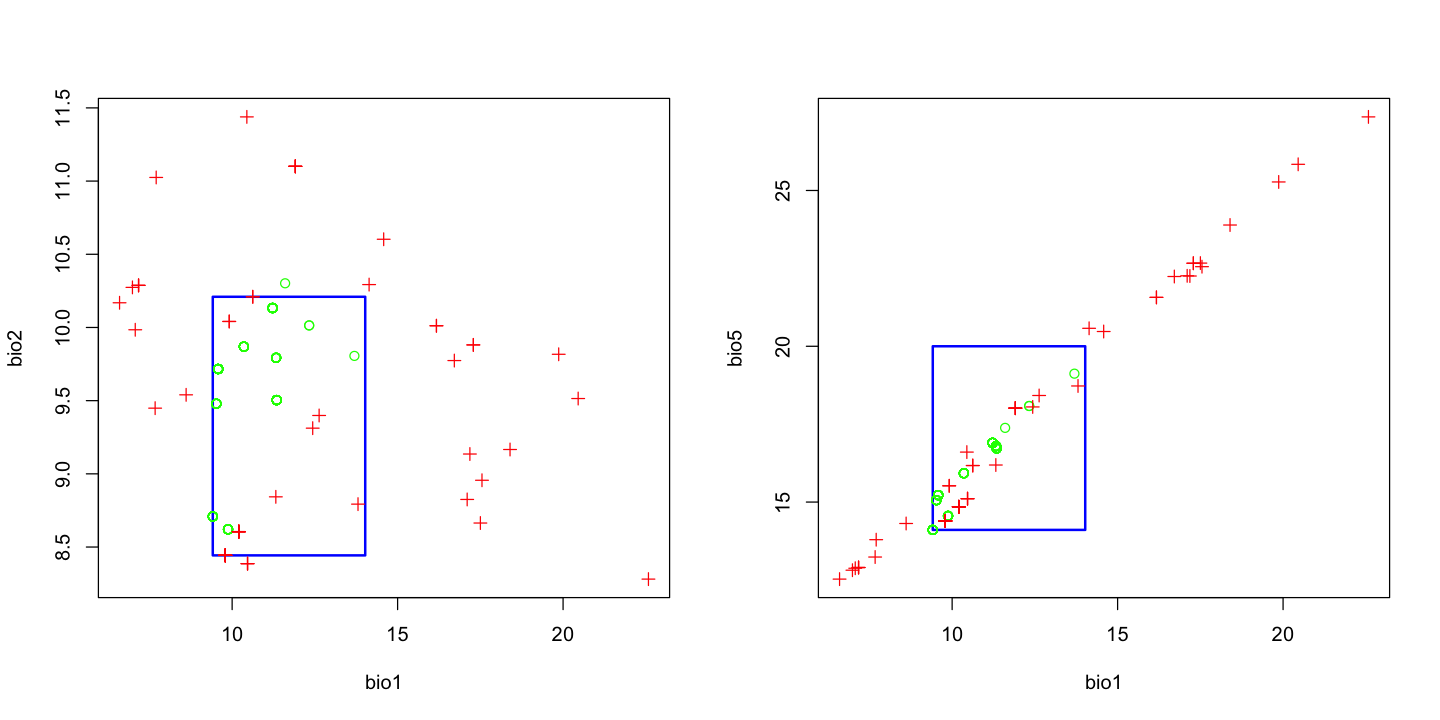

In [22]:
par(mfrow=c(1,2))
plot(bioclim_model, a=1, b=2, p=0.9)
plot(bioclim_model, a=1, b=5, p=0.9)

In that second plot, note that these two variables (mean annual temperature `BIO1` and
maximum temperature of the warmest month 'BIO5') are **extremely strongly correlated**.
This is not likely to be an issue for this method, but in many models it is a **very bad
idea** to have strongly correlated explanatory variables: it is called
**[multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)** and can cause
serious statistical issues. We will revisit this in the GLM example further down.

#### Model predictions

We've now fitted our model and can use the model parameters to predict the `bioclim`
score for the whole map. Note that a lot of the map has a **score of zero**: none of the
environmental variables in these cells fall within the range seen in the occupied cells.

In [23]:
options(repr.plot.width=9, repr.plot.height= 8) # Change plot sizes (in cm)

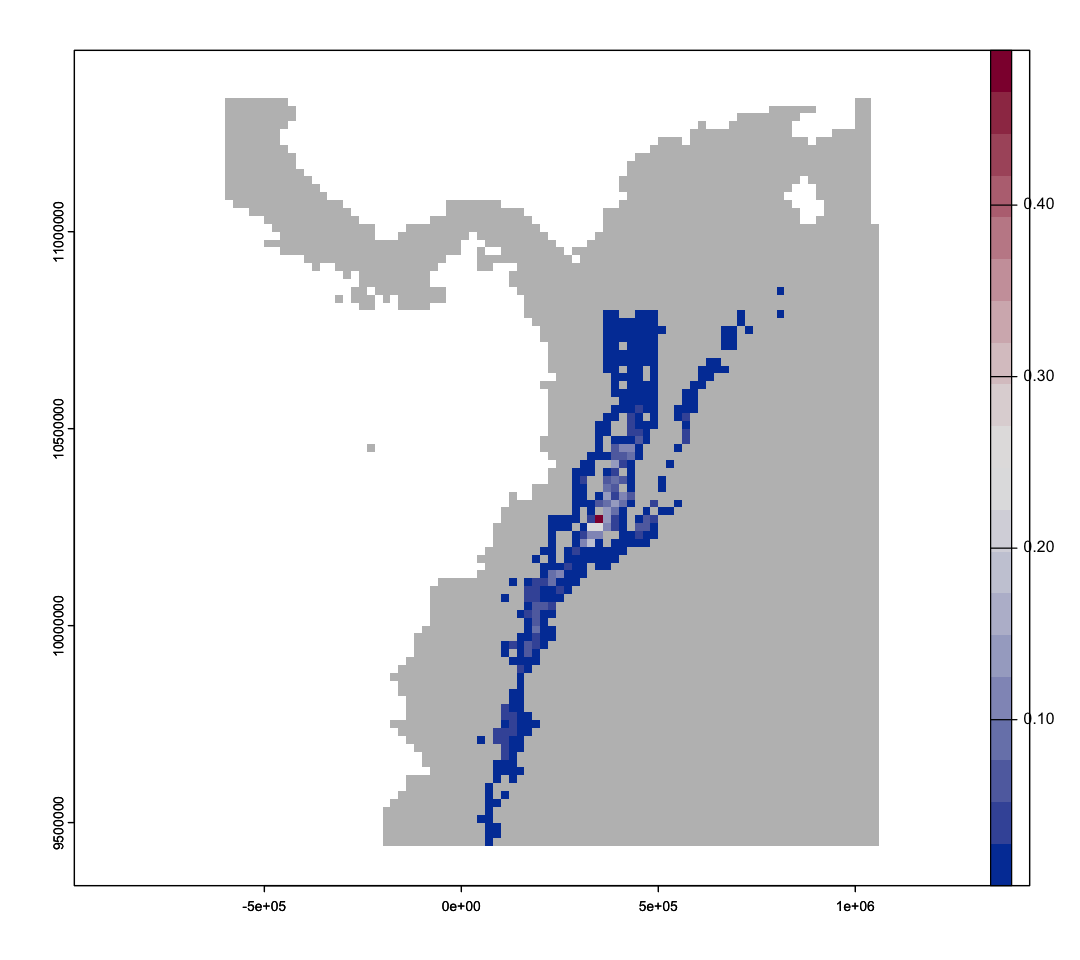

In [24]:
bioclim_pred <- predict(bioclim_hist_local, bioclim_model)

# Create a copy removing zero scores to focus on within envelope locations
bioclim_non_zero <- bioclim_pred
bioclim_non_zero[bioclim_non_zero == 0] <- NA
plot(land, col='grey', legend=FALSE)
plot(bioclim_non_zero, col=hcl.colors(20, palette='Blue-Red'), add=TRUE)

#### Model evaluation

We can also now evaluate our model using the retained test data. Note that here, we do
have to **provide absence data**: all of the standard performance metrics come from a
confusion matrix, which requires false and true negatives. The output of `evaluate`
gives us some key statistics, including AUC.

In [25]:
test_locs <- st_coordinates(subset(tapir_GBIF, kfold == 1))
test_pseudo <- st_coordinates(subset(pseudo_nearby, kfold == 1))
bioclim_eval <- evaluate(p=test_locs, a=test_pseudo, 
                         model=bioclim_model, x=bioclim_hist_local)
print(bioclim_eval)

class          : ModelEvaluation 
n presences    : 77 
n absences     : 77 
AUC            : 0.9646652 
cor            : 0.7652315 
max TPR+TNR at : 0.03257974 


We can also create some standard plots. One plot is the ROC curve and the other is a
graph of how kappa changes as the threshold used on the model predictions varies. The
`threshold` function allows us to find an optimal threshold for a particular measure of
performance: here we find the threshold that gives the best kappa.

In [26]:
options(repr.plot.width=10, repr.plot.height=5) # Change plot sizes (in cm)

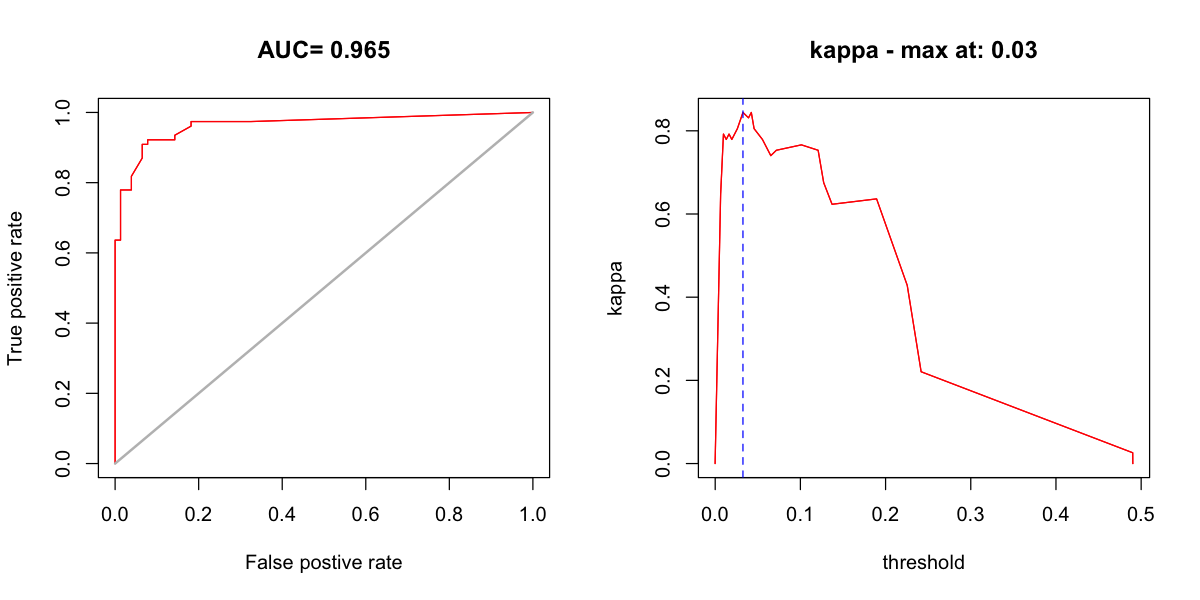

In [27]:
par(mfrow=c(1,2))

# Plot the ROC curve
plot(bioclim_eval, 'ROC', type='l')

# Find the maximum kappa and show how kappa changes with the model threshold
max_kappa <- threshold(bioclim_eval, stat='kappa')
plot(bioclim_eval, 'kappa', type='l')
abline(v=max_kappa, lty=2, col='blue')

#### Species distribution

That gives us all the information we need to make a prediction about the species
distribution:

In [28]:
options(repr.plot.width=8, repr.plot.height= 8) # Change plot sizes (in cm)

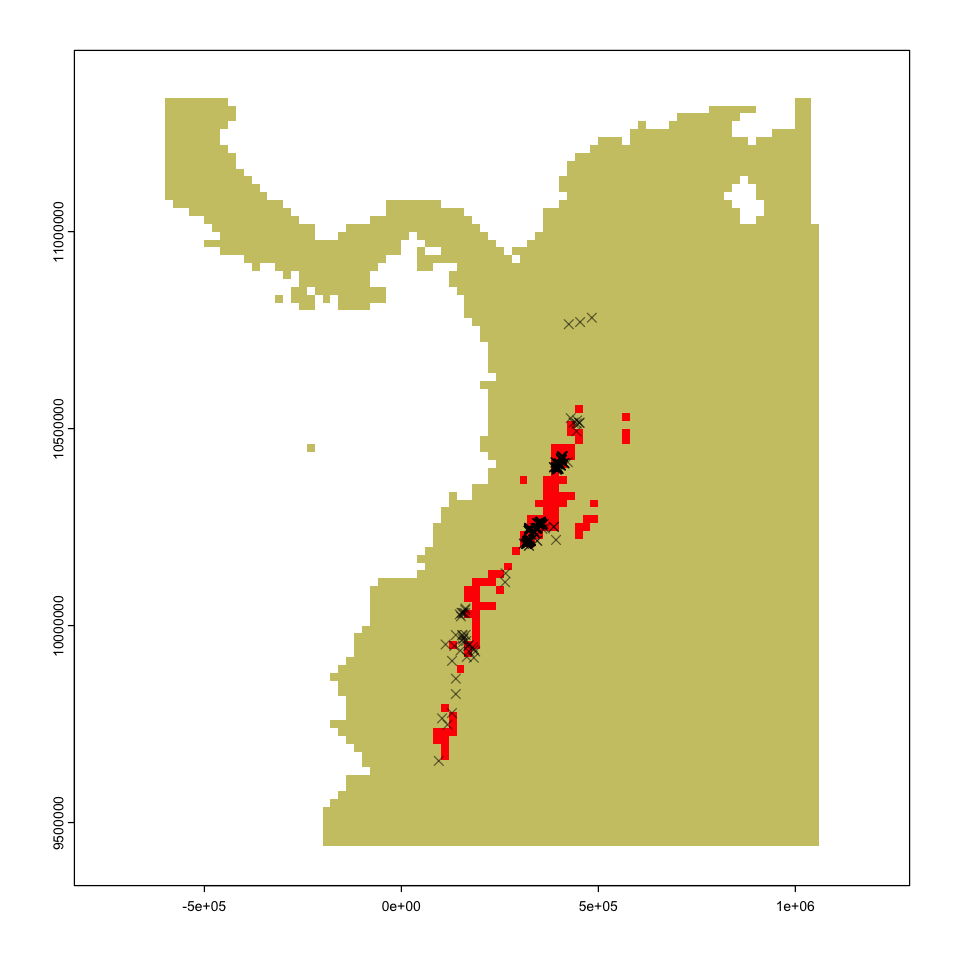

In [29]:
# Apply the threshold to the model predictions
tapir_range <- bioclim_pred >= max_kappa
plot(tapir_range, legend=FALSE, col=c('khaki3','red'))
plot(st_geometry(tapir_GBIF), add=TRUE, pch=4, col='#00000088')

```{admonition} Future distribution of the tapir

The figure below shows the predicted distribution of the Mountain Tapir in 2050 and the
predicted range change - can you figure out how to create these plots?

```

In [30]:
options(repr.plot.width=14, repr.plot.height= 5) # Change plot sizes (in cm)

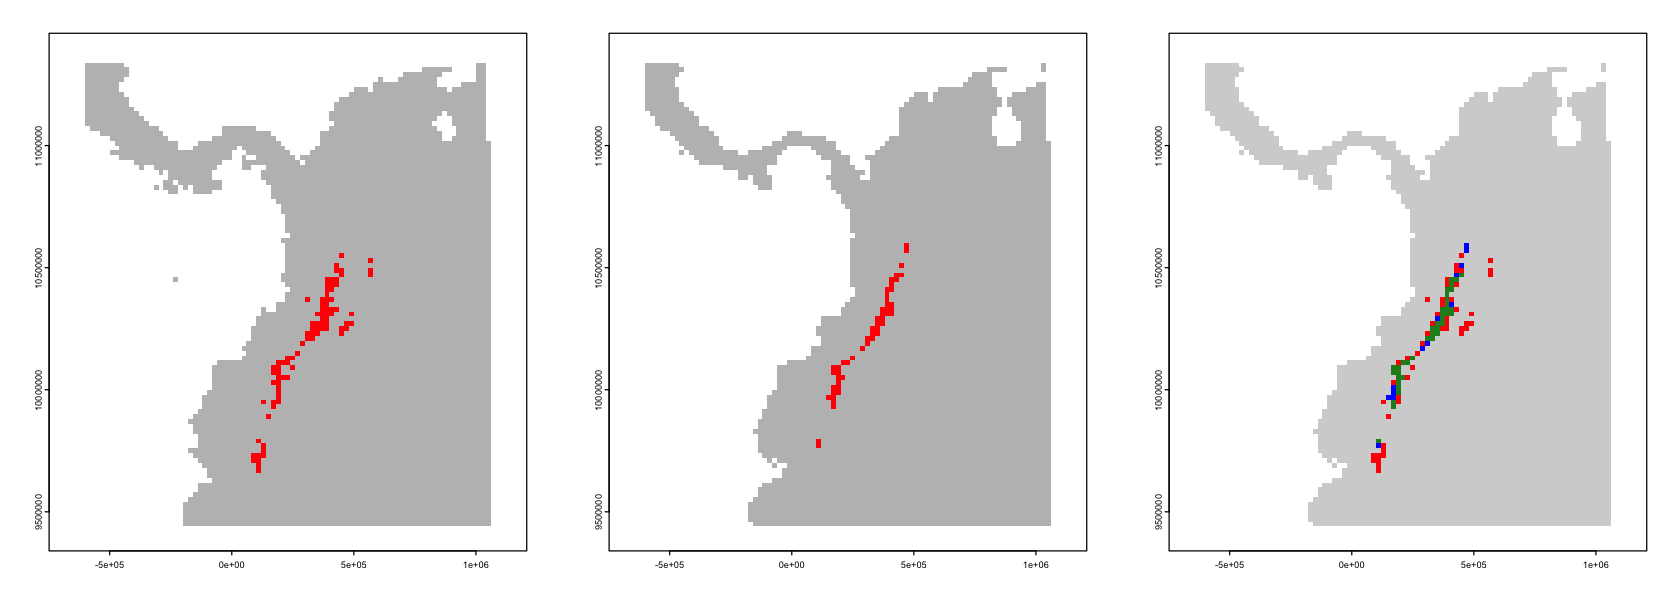

In [31]:
# Predict from the same model but using the future data
bioclim_pred_future <- predict(bioclim_future_local, bioclim_model)
# Apply the same threshold
tapir_range_future <- bioclim_pred_future >= max_kappa

par(mfrow=c(1,3), mar=c(2,2,1,1))
plot(tapir_range, legend=FALSE, col=c('grey','red'))
plot(tapir_range_future, legend=FALSE, col=c('grey','red'))

# This is a bit of a hack - adding 2 * hist + 2050 gives:
# 0 + 0 - present in neither model
# 0 + 1 - only in future
# 2 + 0 - only in hist
# 2 + 1 - in both
tapir_change <- 2 * (tapir_range) + tapir_range_future
cols <- c('lightgrey', 'blue', 'red', 'forestgreen')
plot(tapir_change, col=cols, legend=FALSE)
legend('topleft', fill=cols, legend=c('Absent','Future','Historical', 'Both'), bg='white')

### Generalised Linear Model (GLM)

We are going to jump the gun a bit here and use a GLM. You will cover the statistical
background for this later in the course, but essentially it is a kind of regression that
allows us to model presence/absence as a **binary response variable** more
appropriately. **Do not worry about the statistical details here**: we will treat this
as just another algorithm for predicting species presence. You will learn about GLMs
later in more theoretical depth - they are hugely useful.

#### Data restructuring

The `bioclim` model allowed us just to provide points and some maps but many other
distribution models require us to use a **model formula**, as you saw last week with
linear models. So we need to restructure our data into a data frame of species
presence/absence and the environmental values observed at the locations of those
observations.

First, we need to combine `tapir_GBIF` and `pseudo_nearby` into a single data frame:

In [32]:
# Create a single sf object holding presence and pseudo-absence data.
# - reduce the GBIF data and pseudo-absence to just kfold and a presence-absence value
present <- subset(tapir_GBIF, select='kfold')
present$pa <- 1
absent <- pseudo_nearby
absent$pa <- 0

# - rename the geometry column of absent to match so we can stack them together.
names(absent) <- c('geometry','kfold','pa')
st_geometry(absent) <- 'geometry'

# - stack the two dataframes
pa_data <- rbind(present, absent)
print(pa_data)

Simple feature collection with 766 features and 2 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 277.6292 ymin: 9566234 xmax: 576127.7 ymax: 10870380
Projected CRS: WGS 84 / UTM zone 18S
First 10 features:
   kfold pa                  geometry
1      2  1    POINT (149798 9936513)
3      2  1  POINT (156685.1 9964925)
7      4  1  POINT (134253.4 9948230)
8      3  1 POINT (429786.7 10526533)
9      2  1 POINT (436714.8 10515131)
10     2  1    POINT (163066 9976153)
11     2  1 POINT (148013.6 10028318)
12     4  1 POINT (152531.1 10032452)
13     5  1 POINT (155490.2 10031935)
14     3  1 POINT (157889.8 10032259)


Second, we need to extract the environmental values for each of those points and add it
into the data frame.

In [33]:
envt_data <- extract(bioclim_hist_local, pa_data)
pa_data <- cbind(pa_data, envt_data)
print(pa_data)

Simple feature collection with 766 features and 22 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 277.6292 ymin: 9566234 xmax: 576127.7 ymax: 10870380
Projected CRS: WGS 84 / UTM zone 18S
First 10 features:
   kfold pa ID      bio1      bio2     bio3     bio4     bio5      bio6
1      2  1  1  7.072452  9.984288 85.62547 51.81070 12.87623  1.217051
3      2  1  2  7.172537 10.287475 88.36607 42.57916 12.89965  1.263602
7      4  1  3  7.705094 11.024811 89.50469 34.83894 13.79287  1.483661
8      3  1  4 17.549557  8.956165 90.82992 30.61368 22.55479 12.695293
9      2  1  5 17.184124  9.135429 91.14763 30.10217 22.25498 12.229358
10     2  1  6  9.911862 10.040993 88.04670 42.08802 15.52201  4.118061
11     2  1  7 11.909942 11.100656 89.72603 20.09789 18.01456  5.639944
12     4  1  8 11.909942 11.100656 89.72603 20.09789 18.01456  5.639944
13     5  1  9 11.909942 11.100656 89.72603 20.09789 18.01456  5.639944
14     3  1 10 11.909942 11.100656 89.72603 20.09789 

#### Fitting the GLM

We can now fit the GLM using a model formula: the `family=binomial(link = "logit")` is
the change that allows us to model binary data better, but we do not need the gory
details here.

Three things you do need to know:

- The number of bioclim variables has been reduced from the full set of 19 down to five.
  This is because of the issue of multicollinearity - some pairs of `bioclim` variables
  are very strongly correlated. The five variables are chosen to represent related
  groups of variables ([show me how!](#reducing-the-set-of-variables)).

- The `subset` argument is used to hold back one of the `kfold` partitions for testing.

- The `predict` method for a GLM needs an extra argument (`type='response'`) to make it
  give us predictions as the probability of species occurence. The default model
  prediction output (`?predict.glm`) is on the _scale of the linear predictors_ - do not
  worry about what this means now, but note that there are a few places where we need to
  make this change from the default.

The model fitting code is:

In [34]:
glm_model <- glm(pa ~ bio2 + bio4 + bio3 + bio1 + bio12, data=pa_data, 
                 family=binomial(link = "logit"),
                 subset=kfold != 1)

Using a GLM gives us the significance of different variables - this table is very
similar to a linear model summary. It is interpreted in much the same way.

In [35]:
# Look at the variable significances - which are important
summary(glm_model)


Call:
glm(formula = pa ~ bio2 + bio4 + bio3 + bio1 + bio12, family = binomial(link = "logit"), 
    data = pa_data, subset = kfold != 1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4869  -0.1347   0.0818   0.3112   3.3850  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.816e+01  1.357e+01  -4.285 1.83e-05 ***
bio2         8.191e-01  2.868e-01   2.856   0.0043 ** 
bio4        -6.465e-03  2.725e-02  -0.237   0.8124    
bio3         6.434e-01  1.441e-01   4.465 8.02e-06 ***
bio1        -8.240e-01  7.718e-02 -10.677  < 2e-16 ***
bio12        2.284e-03  4.472e-04   5.108 3.26e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 848.41  on 611  degrees of freedom
Residual deviance: 242.27  on 606  degrees of freedom
AIC: 254.27

Number of Fisher Scoring iterations: 7


It can also be helpful to look at **response plots**: these show how the probability of
a species being present changes with a given variable. These are predictions for each
variable in turn, holding all the other variables at their median value.

In [36]:
options(repr.plot.width=10, repr.plot.height= 10) # Change plot sizes (in cm)

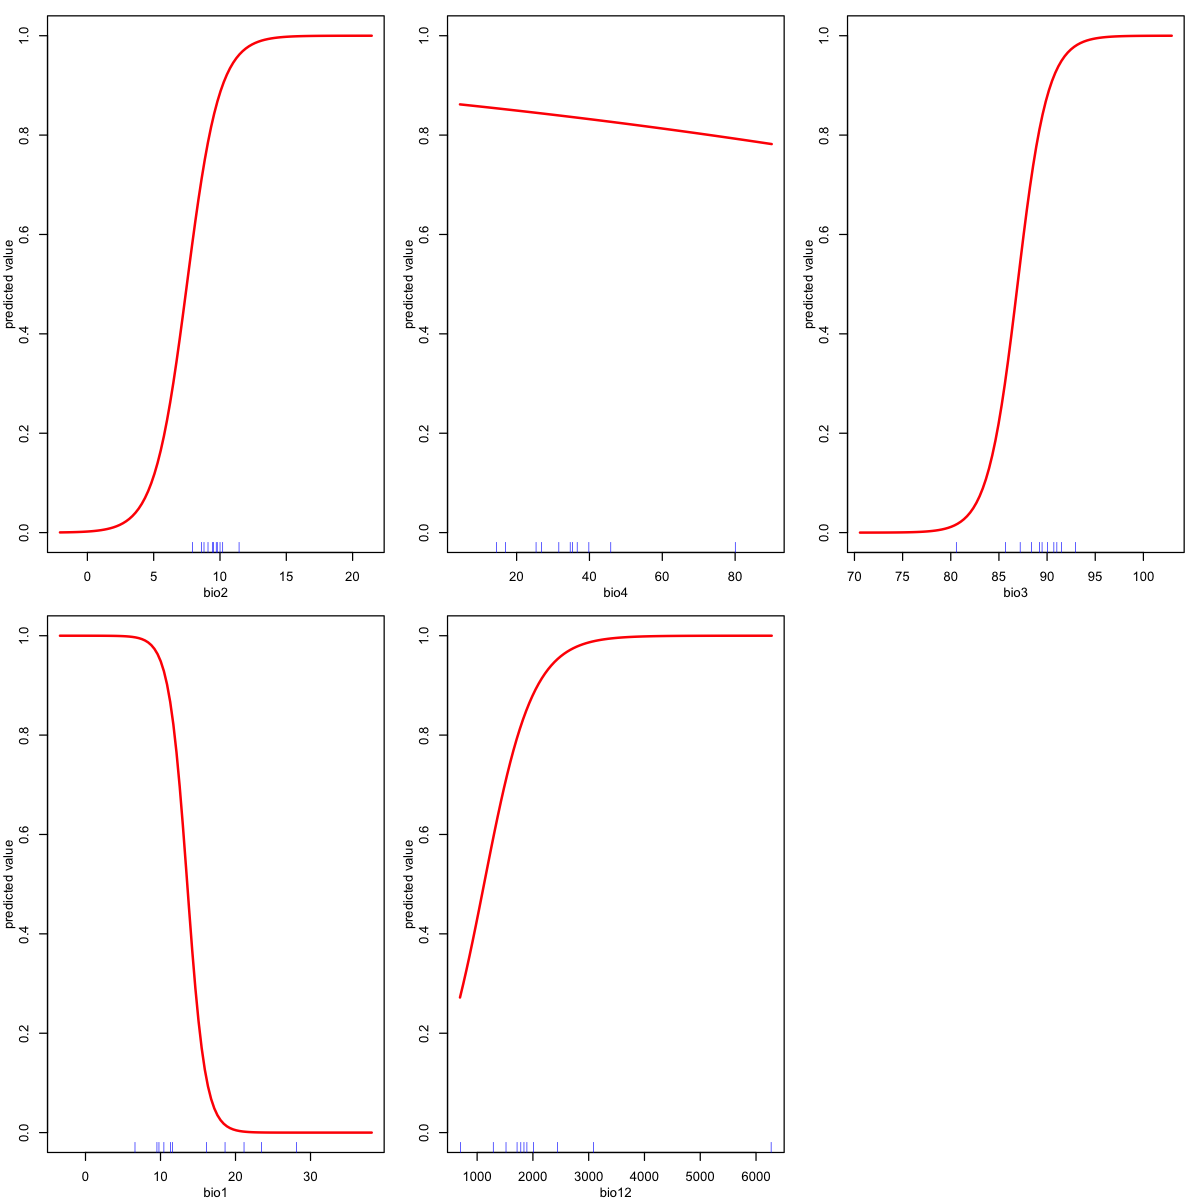

In [37]:
# Response plots
par(mar=c(3,3,1,1), mgp=c(2,1,0))
response(glm_model, fun=function(x, y, ...) predict(x, y, type='response', ...))

#### Model predictions and evaluation

We can now evaluate our model using the same techniques as before:

1. Create a prediction layer.

In [38]:
glm_pred <- predict(bioclim_hist_local, glm_model, type='response')

1. Evaluate the model using the test data.

In [39]:
# Extract the test presence and absence
test_present <- st_coordinates(subset(pa_data, pa == 1 & kfold == 1))
test_absent <- st_coordinates(subset(pa_data, pa == 0 & kfold == 1))
glm_eval <- evaluate(p=test_present, a=test_absent, model=glm_model, 
                     x=bioclim_hist_local)
print(glm_eval)

class          : ModelEvaluation 
n presences    : 77 
n absences     : 77 
AUC            : 0.9937595 
cor            : 0.8262676 
max TPR+TNR at : 1.103575 


1. Find the maximum kappa threshold. This is a little more complicated than before the
   threshold we get is again on the _scale of the linear predictor_. For this kind of
   GLM, we can use `plogis` to convert back.

In [40]:
max_kappa <- plogis(threshold(glm_eval, stat='kappa'))
print(max_kappa)

[1] 0.7509294


1. Look at some model performance plots

In [41]:
options(repr.plot.width=9, repr.plot.height= 5) # Change plot sizes (in cm)

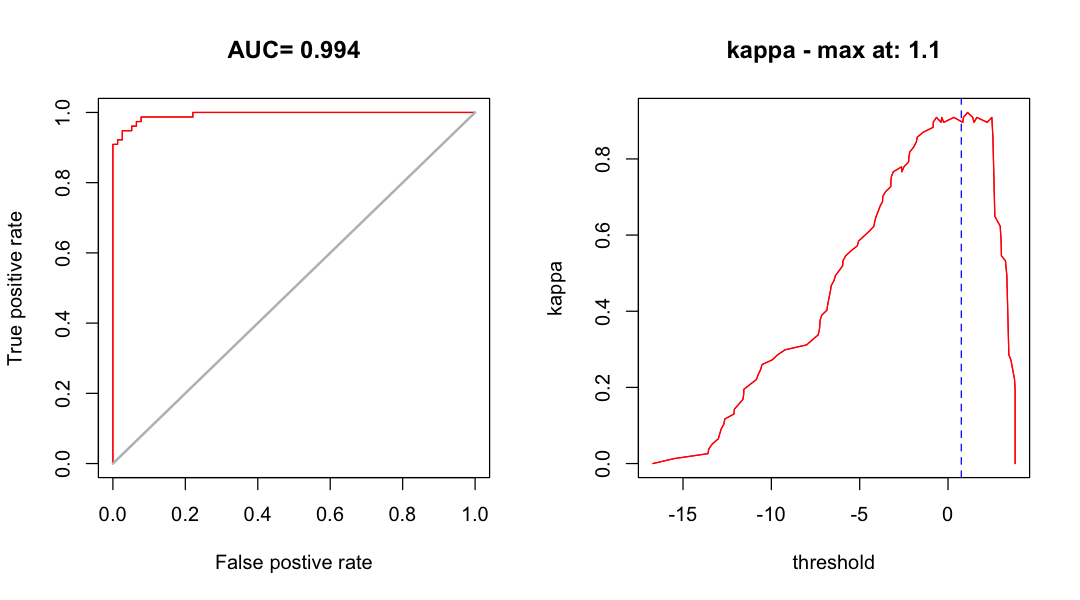

In [42]:
par(mfrow=c(1,2))
# ROC curve and kappa by model threshold
plot(glm_eval, 'ROC', type='l')
plot(glm_eval, 'kappa', type='l')
abline(v=max_kappa, lty=2, col='blue')

#### Species distribution from GLM

We can now again use the threshold to convert the model outputs into a predicted
species' distribution map and compare current suitability to future suitability.

In [43]:
options(repr.plot.width=8, repr.plot.height= 8) # Change plot sizes (in cm)

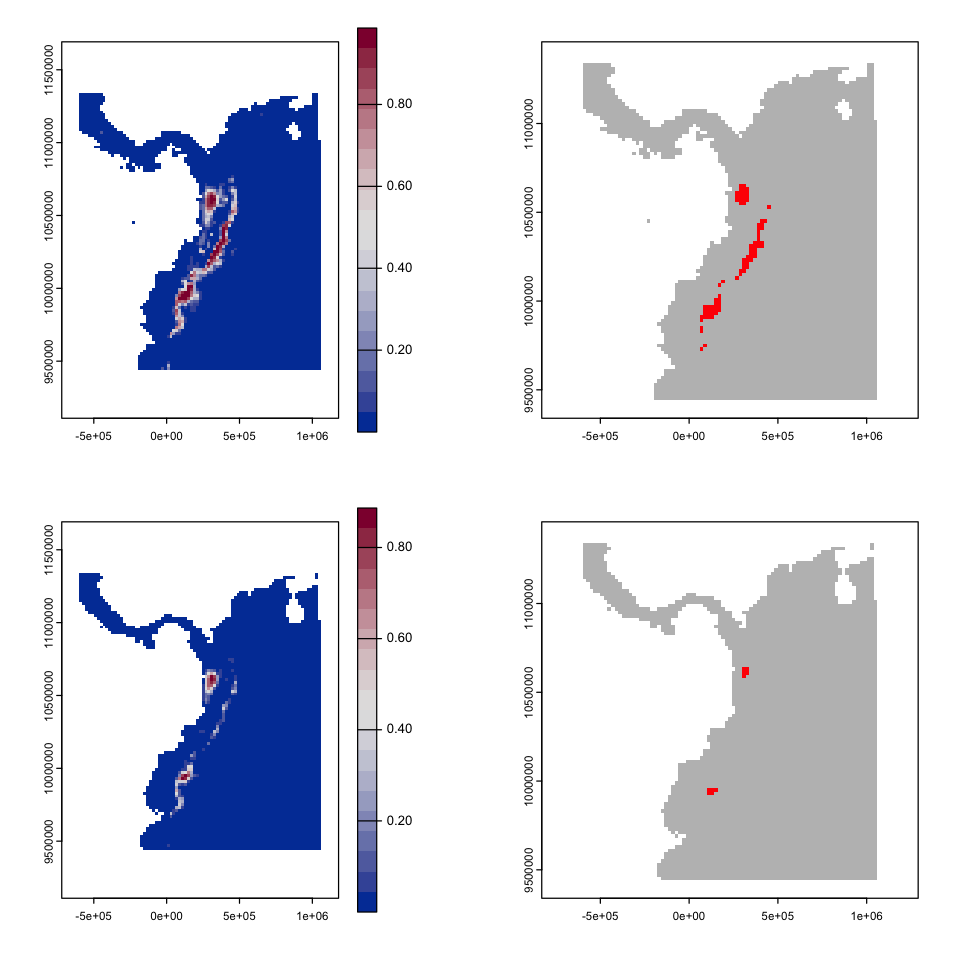

In [44]:
par(mfrow=c(2,2))

# Modelled probability
plot(glm_pred, col=hcl.colors(20, 'Blue-Red'))

# Threshold map
glm_map <- glm_pred >= max_kappa
plot(glm_map, legend=FALSE, col=c('grey','red'))

# Future predictions
glm_pred_future <- predict(bioclim_future_local, glm_model, type='response')
plot(glm_pred_future, col=hcl.colors(20, 'Blue-Red'))

# Threshold map
glm_map_future <- glm_pred_future >= max_kappa
plot(glm_map_future, legend=FALSE, col=c('grey','red'))

One simple way to describe the modelled changes is simply to look at a table of the pair
of model predictions:

In [45]:
table(values(glm_map), values(glm_map_future), dnn=c('hist', '2050'))

    2050
hist    0    1
   0 4377    0
   1   74   10

This GLM predicts a significant loss of existing range for this species by
2041 - 2060 and no expansion into new areas.

## Sandbox - things to try with SDMs

The previous sections have introduced the main approaches for fitting and assessing
models so the following sections are intended to give you some things to try. You do not
have to try all of them in the practical - pick things that interest you and give them a
go.

One of the things to take away from these options are that SDMs have an extremely wide
range of options, so testing and comparing many approaches is vital to identifying the
features of model predictions that are comparable.

### Modelling a different species

The environmental data is global, so we can use it to model any terrestrial organism for
which we can get location data. So:

1. Have a look at the [GBIF species data page](https://www.gbif.org/species/search) and
   pick a species you would like to model. It probably makes sense to pick something
   with a relatively limited range.

1. You can the easily get the recorded points using the `dismo` function `gbif`. The
   example below gets the data for the Mountain Tapir direct from GBIF. It is worth
   running the command with `download=FALSE` first to get an idea of the number of
   records you will get - pick a species that has a few thousand at most.

In [46]:
# Check the species without downloading - this shows the number of records
gbif('Tapirus', 'pinchaque', download=FALSE)

[1] 590

In [47]:
# Download the data
locs <- gbif('Tapirus', 'pinchaque')
locs <- subset(locs, ! is.na(lat) | ! is.na(lon))
# Convert to an sf object 
locs <- st_as_sf(locs, coords=c('lon', 'lat'))

590 records found



0-


300-


590 records downloaded



1. You will then need to clean the GBIF points - have a look at the `sdm` vignette
   mentioned above for ways to tackle cleaning the data. One tip - check the
   `basisOfRecord` field because the GBIF occurence database includes things like the
   location of museum specimens. It is _much_ harder to identify species introductions
   though.

1. Select an appropriate extent for the modelling and update `model_extent`.

1. Follow the process above to create your model.

### Does our background choice matter?

The examples above have used the spatially structured background data. Does this matter?
The plot below compares the GLM fitted with the structured background to the wider
sample created using `randomPoints`. Can you create this model?

In [48]:
options(repr.plot.width=12, repr.plot.height= 4) # Change plot sizes (in cm)

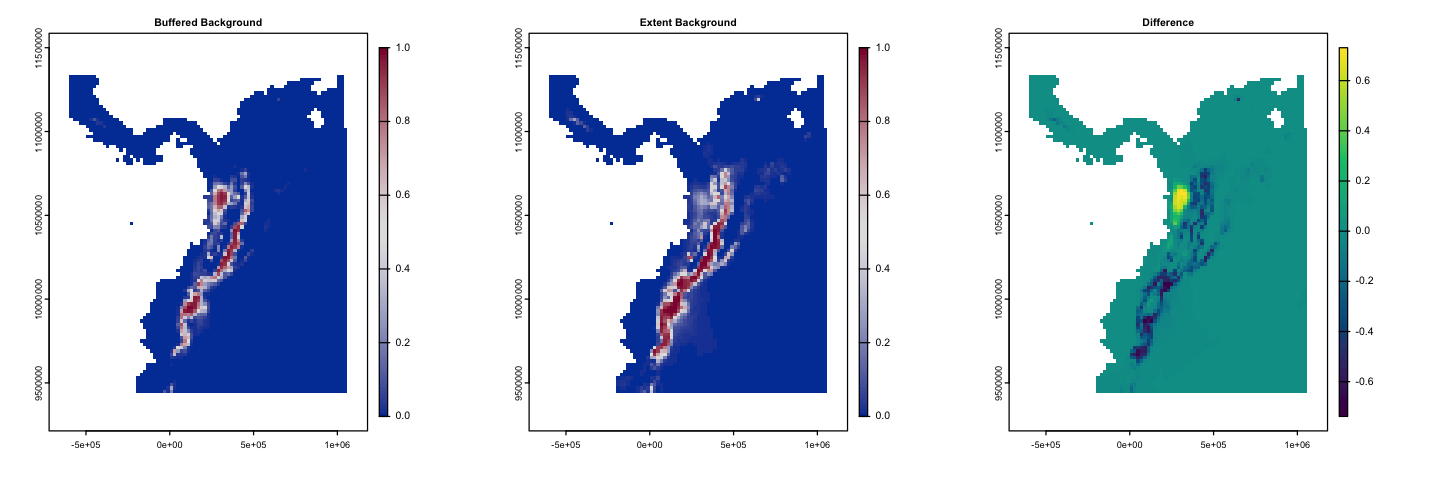

In [49]:
# 1. Create the new dataset
present <- subset(tapir_GBIF, select='kfold')
present$pa <- 1
absent <- pseudo_dismo
absent$pa <- 0

# - rename the geometry column of absent to match so we can stack them together.
names(absent) <- c('geometry','kfold','pa')
st_geometry(absent) <- 'geometry'
# - stack the two dataframes
pa_data_bg2 <- rbind(present, absent)
# - Add the envt.
envt_data <- extract(bioclim_hist_local, pa_data_bg2)
pa_data_bg2 <- cbind(pa_data_bg2, envt_data)

# 2. Fit the model
glm_model_bg2 <-glm(pa ~ bio2 + bio4 + bio3 + bio1 + bio12, data=pa_data_bg2, 
                  family=binomial(link = "logit"),
                  subset=kfold != 1)

# 3. New predictions
glm_pred_bg2 <- predict(bioclim_hist_local, glm_model_bg2, type='response')

# 4. Plot modelled probability using the same colour scheme and using
# axis args to keep a nice simple axis on the legend
par(mfrow=c(1,3))
bks <- seq(0, 1, by=0.01)
cols <- hcl.colors(100, 'Blue-Red')
plot(glm_pred, col=cols, breaks=bks, main='Buffered Background', 
     type='continuous', plg=list(ext=c(1.25e6, 1.3e6, 9.3e6, 11.5e6)))
plot(glm_pred_bg2, col=cols, breaks=bks, main='Extent Background',
     type='continuous', plg=list(ext=c(1.25e6, 1.3e6, 9.3e6, 11.5e6)))
plot(glm_pred - glm_pred_bg2, col= hcl.colors(100), main='Difference',
     type='continuous', plg=list(ext=c(1.25e6, 1.3e6, 9.3e6, 11.5e6)))

### Cross validation

```{attention}
This exercise calls for more programming skills - you need to be able to write a loop
and set up object to store data for each iteration through the loop.
```

The models above always use the same partitions for testing and training. A better
approach is to perform **k-fold cross validation** to check that the model behavour is
consistent across different partitions. This allows you to compare the performance of
models taking into account the arbitrary structure of the partitioning.

Here, we have used a completely random partition of the data, but it is worth looking at
this recent paper arguing for a spatially structured approach to data partitions in SDM
testing:

> Valavi, R, Elith, J, Lahoz‐Monfort, JJ, Guillera‐Arroita, G. blockCV: An r package for
> generating spatially or environmentally separated folds for k‐fold cross‐validation of
> species distribution models. Methods Ecol Evol. 2019; 10: 225– 232.
> [https://doi.org/10.1111/2041-210X.13107](https://doi.org/10.1111/2041-210X.13107)

Try and create the output below, collecting the ROC lines and AUCs across all five
possible test partitions of the GLM model. There are two things here that are more
difficult:

1. A way to get the ROC data from the output of `evaluate` - this is not obvious because
   `dismo` uses a different coding approach
   ([S4 methods](http://adv-r.had.co.nz/S4.html)) that is a bit more obscure. Don't
   worry about this - just use the function! Similarly, you need to know that to get the
   AUC value, you need to use `glm_eval@auc`.

In [50]:
get_roc_data <- function(eval){
    #' get_roc_data
    #' 
    #' This is a function to return a dataframe of true positive
    #' rate and false positive rate from a dismo evalulate output
    #' 
    #' @param eval An object create by `evaluate` (S4 class ModelEvaluation)
    
    roc <- data.frame(FPR = eval@FPR, TPR = eval@TPR)
    return(roc)
}

1. You want each model evaluation to be carried out using the **same threshold
   breakpoints**, otherwise it is difficult to align the outputs of the different
   partitions. We can give `evaluate` a set of breakpoints but - for the GLM - the
   breakpoints are on that mysterious _scale of the linear predictors_. The following
   approach allows you to set those breakpoints.

In [51]:
# Take a sequence of probability values from 0 to 1
thresholds <- seq(0, 1, by=0.01)
# Convert to the default scale for a binomial GLM
thresholds <- qlogis(thresholds)
# Use in evaluate
eval <- evaluate(p=test_present, a=test_absent, model=glm_model, 
                  x=bioclim_hist_local, tr=thresholds)

The ouputs below show the AUC and ROC curve for each of the $k$-fold partitions and the
average across partitions. See if you can calculate these!

In [52]:
options(repr.plot.width=5, repr.plot.height=5) # Change plot sizes (in cm)

[1] 0.9937595 0.9830332 0.9662675 0.9714335 0.9853264


[1] 0.979964


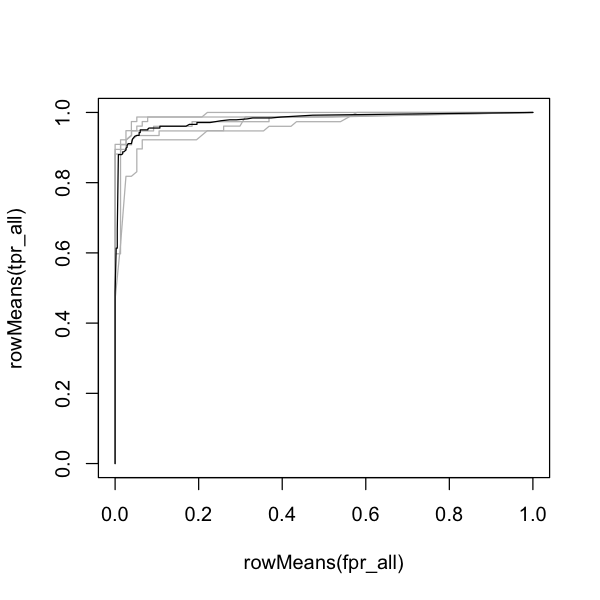

In [53]:
# Make some objects to store the data
tpr_all <- matrix(ncol=5, nrow=length(thresholds))
fpr_all <- matrix(ncol=5, nrow=length(thresholds))
auc <- numeric(length=5)

# Loop over the values 1 to 5
for (test_partition in 1:5) {

    # Fit the model, holding back this test partition
    model <- glm(pa ~ bio2 + bio4 + bio3 + bio1 + bio12, data=pa_data, 
                 family=binomial(link = "logit"),
                 subset=kfold != test_partition)
    
    # Evaluate the model using the retained partition
    test_present <- st_coordinates(subset(pa_data, pa == 1 & kfold == test_partition))
    test_absent <- st_coordinates(subset(pa_data, pa == 0 & kfold == test_partition))
    eval <- evaluate(p=test_present, a=test_absent, model=glm_model, 
                     x=bioclim_hist_local, tr=thresholds)

    # Store the data
    auc[test_partition] <- eval@auc
    roc <- get_roc_data(eval)
    tpr_all[,test_partition] <- roc$TPR
    fpr_all[,test_partition] <- roc$FPR
}

# Create a blank plot to showing the mean ROC and the individual traces
plot(rowMeans(fpr_all), rowMeans(tpr_all), type='n')

# Add the individual lines
for (test_partition in 1:5) {
  lines(fpr_all[, test_partition], tpr_all[, test_partition], col='grey')
}

# Add the mean line
lines(rowMeans(fpr_all), rowMeans(tpr_all))

print(auc)
print(mean(auc))

## Reducing the set of variables

The details of this selection process are hidden below. I'm using clustering to find
groups - you do not need to look at this but I do not like hiding my working!

In [54]:
options(repr.plot.width=8, repr.plot.height= 5) # Change plot sizes (in cm)

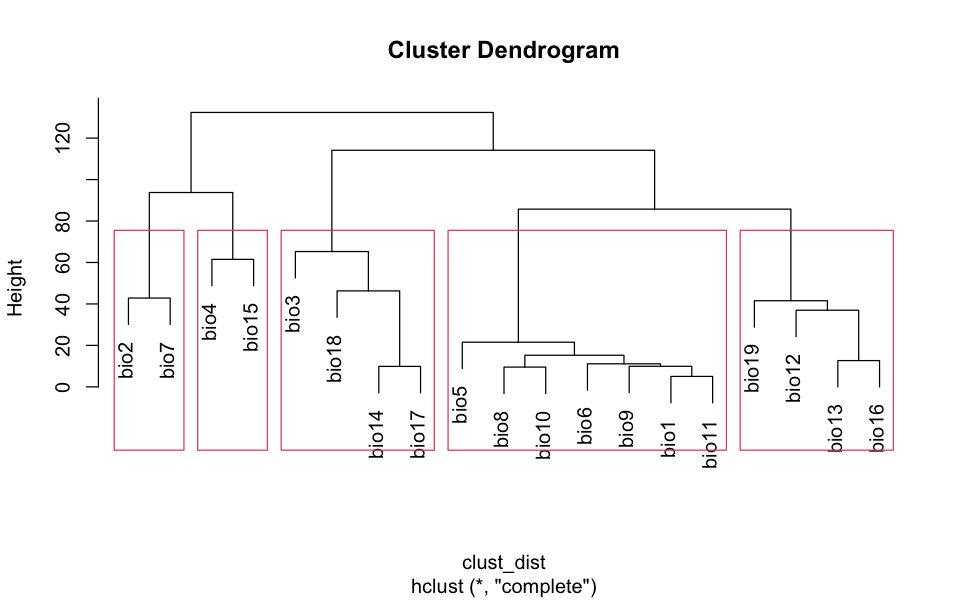

In [55]:
# We can use the values from the environmental data in a cluster algorithm.
# This is a statistical process that groups sets of values by their similarity
# and here we are using the local raster data (to get a good local sample of the 
# data correlation) to perform that clustering.
clust_data <- values(bioclim_hist_local)
clust_data <- na.omit(clust_data)

# Scale and center the data
clust_data <- scale(clust_data)

# Transpose the data matrix to give variables as rows
clust_data <- t(clust_data)

# Find the distance between variables and cluster
clust_dist <- dist(clust_data)
clust_output <- hclust(clust_dist)
plot(clust_output)

# And then pick one from each of five blocks - haphazardly.
rect.hclust(clust_output, k=5)